In [1]:
#Python processing stuff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

#R stuff
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
''' Remove comment if clusrank needs to be downloaded
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('clusrank')
'''
ro.r('library(clusrank)')

#Constants
FILENAME = "ARPY57Data.xlsx" #filename
names = ["NSSCR/min","SCR","SCL",'TVSymp','EDASymp']

In [2]:
def formating(iarr,num,start=0):
    columns = iarr.columns
    unnamed_indices = [i for i, col in enumerate(columns) if "Unnamed" in str(col)]
    dfwa = []
    for i in range(len(unnamed_indices)):
        try:
            dfwa.append(iarr.iloc[:,unnamed_indices[i]:unnamed_indices[i+1]])
        except:
            dfwa.append(iarr.iloc[:,unnamed_indices[i]:])
    sessions = ["baseline 1", "llm", "baseline 2", "text"]
    baseline1 = []
    df1 = []
    baseline2 = []
    df2 = []
    for i in dfwa:
        indices = [i[i.iloc[:,0].str.lower() == keyword].index.tolist()[0] for keyword in sessions]
        indices.sort()
        arr = []
        for j in range(len(indices)):
            try:
                arr.append(pd.DataFrame(i.iloc[indices[j]+1:indices[j+1],1:]).reset_index(drop=True))
            except:
                arr.append(pd.DataFrame(i.iloc[indices[j]+1:,1:]).reset_index(drop=True))
        baseline1.append(arr[0])
        df1.append(arr[1])
        baseline2.append(arr[2])
        df2.append(arr[3])
    arrf = []
    arrf2 = []
    for i in range(len(df1)):
        df1[i] = (df1[i] - baseline1[i].iloc[df1[i].index % 5].reset_index(drop=True)).reset_index(drop=True)
        df2[i] = (df2[i] - baseline2[i].iloc[df2[i].index % 5].reset_index(drop=True)).reset_index(drop=True)
        dft1 = pd.DataFrame()
        dft2 = pd.DataFrame()
        for col in df1[i].columns:
            for j in range(5):
                dft1[f'{names[j]}'] = df1[i][col].iloc[j::5].reset_index(drop=True)
            arrf.append(dft1)
            dft1 = pd.DataFrame()
        for col in df2[i].columns:
            for j in range(5):
                dft2[f'{names[j]}'] = df2[i][col].iloc[j::5].reset_index(drop=True)
            arrf2.append(dft2)
            dft2 = pd.DataFrame()
    for i in arrf:
        i.dropna(inplace=True)
    for i in arrf2:
        i.dropna(inplace=True)
    cd = []
    for i, df in enumerate(arrf):
        cluster = np.full(len(df), i+start)
        df['cluster'] = cluster
        cd.append(df)
    cd2 = []
    for i, df in enumerate(arrf2):
        cluster = np.full(len(df), i+start)
        df['cluster'] = cluster
        cd2.append(df)
    cd3 = []
    if num == 1: #lr
        for i in range(len(cd)):     
            cd3.append(pd.concat([cd[i],cd2[i]],axis=1))
    else: #rl
        for i in range(len(cd)):
            cd3.append(pd.concat([cd2[i],cd[i]],axis=1))
    final_df = pd.concat(cd3, ignore_index=True).iloc[:,:-1]
    return final_df,max(len(arrf),len(arrf2))+start

In [3]:
dfw1 = pd.read_excel(FILENAME,sheet_name=0)
dfwt1,start = formating(dfw1,2) #num=1 for LLM before text, num!=1 for text before LLM.
dfwt1.head(10)

,NSSCR/min,SCR,SCL,TVSymp,EDASymp,cluster,NSSCR/min,SCR,SCL,TVSymp,EDASymp
0,-2.666667,0.714153,-0.917022,0.076726,0.059694,0,7.5,0.444632,-0.556026,-0.007192,-0.015792
1,-3.666667,0.399252,-0.520865,0.05185,0.024988,0,7.5,0.874226,-1.154848,-0.040347,-0.018341
2,-4.0,0.129966,-0.204506,0.026168,0.01757,0,5.833333,0.505762,-0.625073,-0.082847,-0.010999
3,-4.0,-0.023987,0.018152,0.004071,0.014196,0,7.5,0.579914,-0.710646,-0.072297,-0.008364
4,-3.666667,-0.196439,0.243051,0.033798,0.008703,0,1.166667,0.366752,-0.497035,-0.05173,-0.004452
5,3.666667,0.170406,-0.172191,0.000207,-0.001688,1,3,0.207191,-0.254515,0.169025,0.002597
6,2.666667,0.156778,-0.199499,-0.193551,0.013114,1,5.666667,0.122106,-0.151139,0.026795,0.002327
7,0,0.117935,-0.132618,-0.061412,0.001912,1,5,-0.032404,0.062193,-0.05522,0.001233
8,8.333333,0.115122,-0.144198,-0.039911,-0.00426,1,1.333333,0.104757,-0.127845,0.026764,0.002729
9,8,0.11679,-0.154616,0.106243,-0.005562,1,1.666667,0.139681,-0.183574,0.065837,0.002659


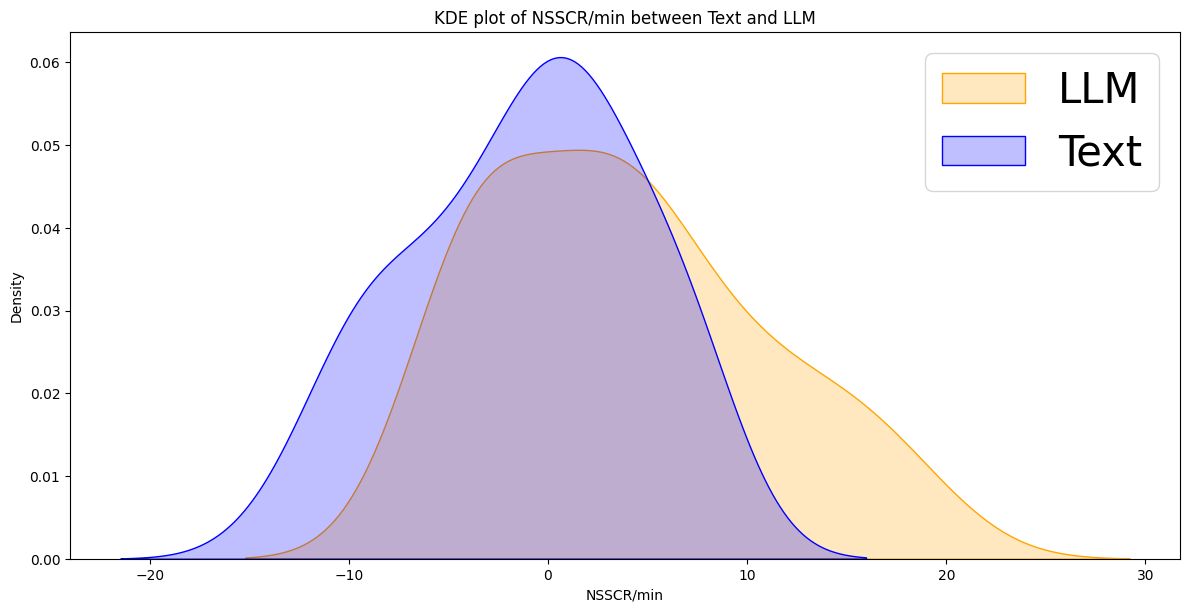

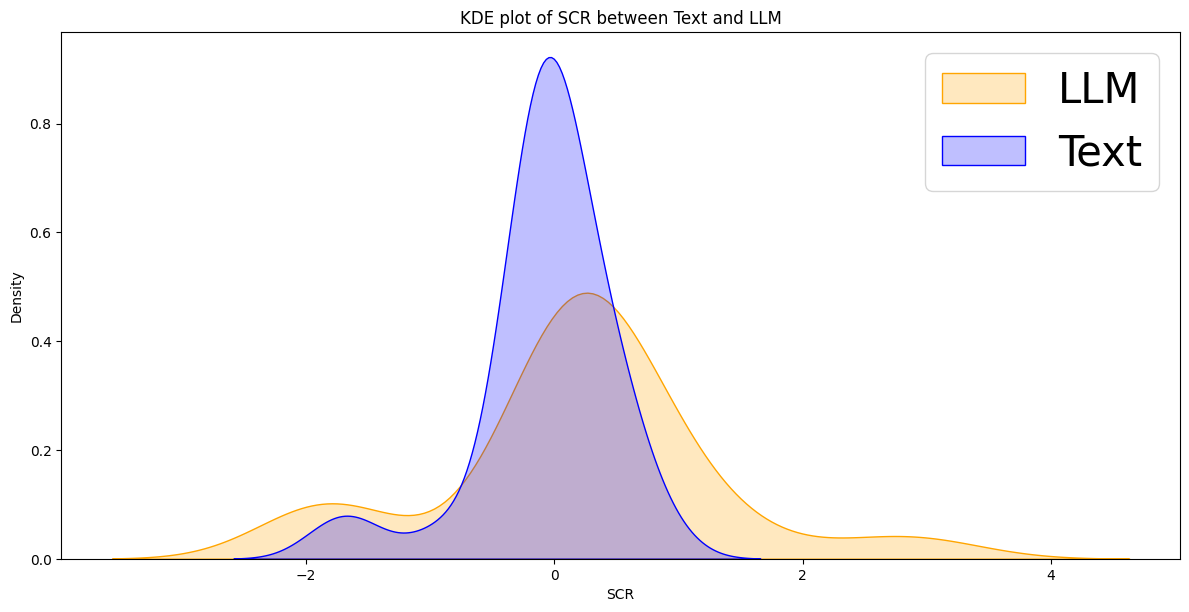

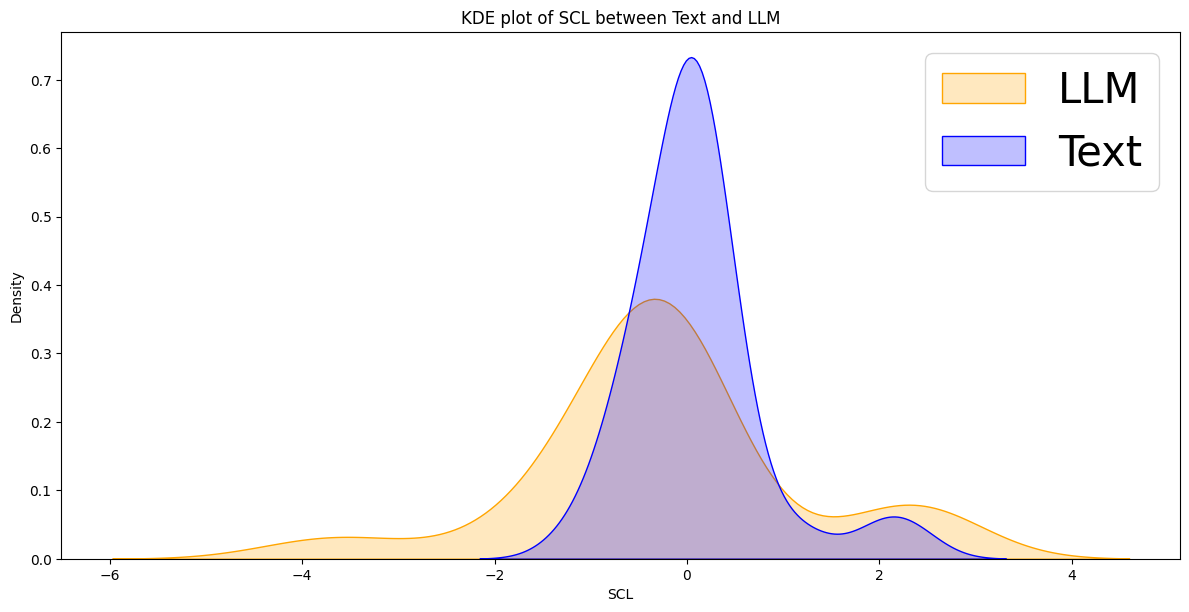

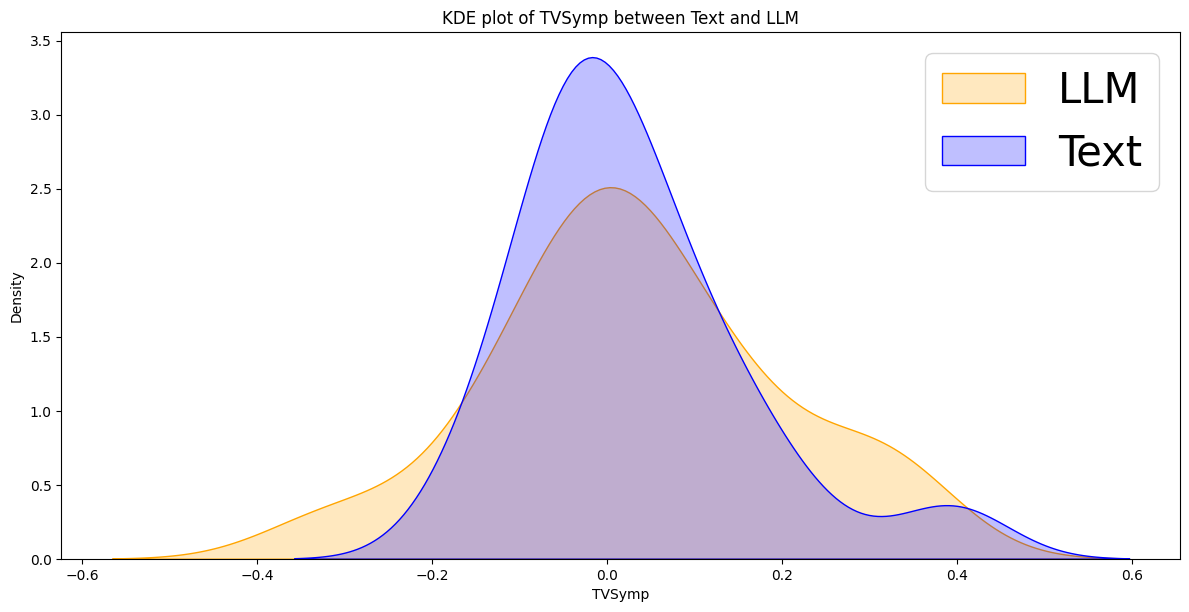

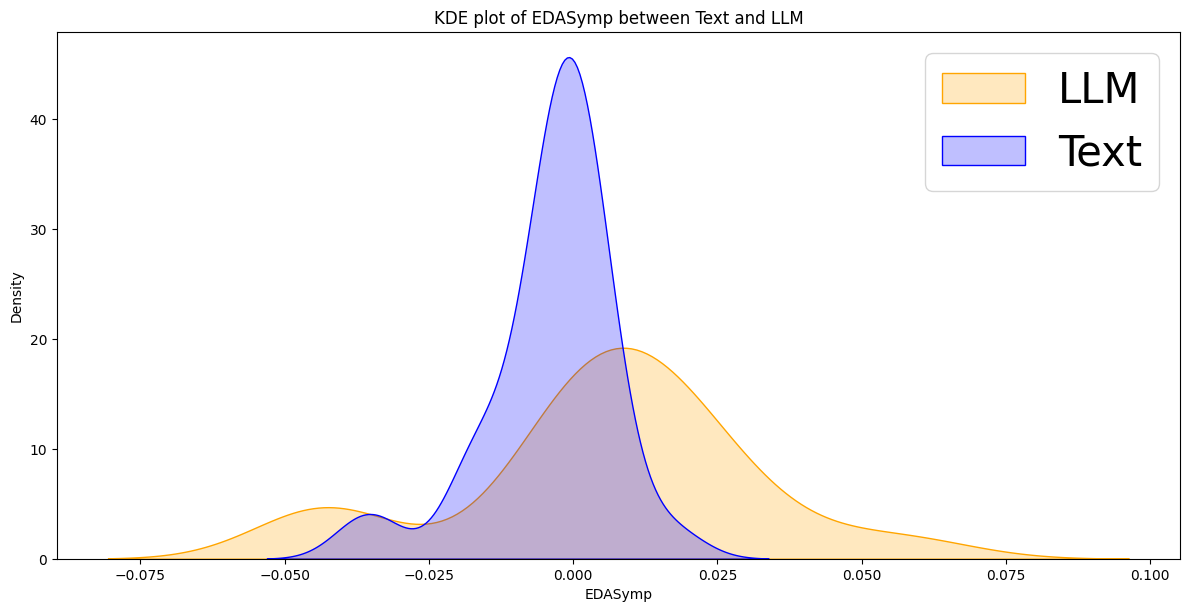

In [4]:
graphdfL = dfwt1.iloc[:,0:5]
graphdfT = dfwt1.iloc[:,6:]
for i in range(5):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.kdeplot(x=graphdfL.iloc[:,i],
            color='orange', label='LLM', fill=True, ax=ax)
    sns.kdeplot(x=graphdfT.iloc[:,i],
            color='blue', label='Text', fill=True, ax=ax)
    ax.legend()
    plt.tight_layout()
    plt.title(f'KDE plot of {names[i]} between Text and LLM')
    plt.legend(fontsize=30)
    ax.set_xlabel(names[i])
    fig.savefig(f'KDEof7_{i}.png',bbox_inches='tight')

In [5]:
rdfwt1 = dfwt1
rdfwt1.columns= range(rdfwt1.shape[1])
with (ro.default_converter + pandas2ri.converter).context():
  r_from_pd_df = ro.conversion.get_conversion().py2rpy(rdfwt1)
ro.r.assign("rd", r_from_pd_df)

for i in range(1, 6):
    ro.r(f"rd[[{i}]] <- as.numeric(rd[[{i}]])")
    ro.r(f"rd[[{i+6}]] <- as.numeric(rd[[{i+6}]])")
ro.r("rd[[6]] <- as.integer(rd[[6]])")
for i in range(1, 6):
    #ro.r(f"result_{i} <- clusWilcox.test(x=rd[[{i}]],y=rd[[{i+6}]], cluster=rd[[6]],paired=TRUE,alternative='l')") #H1: Text>LLM
    ro.r(f"result_{i} <- clusWilcox.test(x=rd[[{i}]],y=rd[[{i+6}]], cluster=rd[[6]],paired=TRUE,alternative='g')") #H1: LLM>Text
    result = ro.r(f"result_{i}")
    print(f"Result for {names[i-1]}:")
    print(result)

Result for NSSCR/min:

	Clustered Wilcoxon signed rank test using Rosner-Glynn-Lee method

data:  [[ and [[; cluster: [[;rd and rd; cluster: rd;1 and 7; cluster: 6;
number of observations: 35;  number of clusters: 7
Z = 1.2201, p-value = 0.1112
alternative hypothesis: true shift in location is greater than 0


Result for SCR:

	Clustered Wilcoxon signed rank test using Rosner-Glynn-Lee method

data:  [[ and [[; cluster: [[;rd and rd; cluster: rd;2 and 8; cluster: 6;
number of observations: 35;  number of clusters: 7
Z = 0.6637, p-value = 0.2534
alternative hypothesis: true shift in location is greater than 0


Result for SCL:

	Clustered Wilcoxon signed rank test using Rosner-Glynn-Lee method

data:  [[ and [[; cluster: [[;rd and rd; cluster: rd;3 and 9; cluster: 6;
number of observations: 35;  number of clusters: 7
Z = -0.68558, p-value = 0.7535
alternative hypothesis: true shift in location is greater than 0


Result for TVSymp:

	Clustered Wilcoxon signed rank test using Rosner-Glyn

//anaconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "0". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'int'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
//anaconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "1". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
//anaconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "2". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
//anaconda3/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Er

In [6]:
testdf = pd.read_excel(FILENAME,sheet_name=1)
testres = wilcoxon((testdf.iloc[:,0]-testdf.iloc[:,1]).dropna(),alternative='less',method = 'approx')
print(f'Mdn = {testdf.iloc[:,0].median()}, Mdn = {testdf.iloc[:,1].median()}')
print(f'W = {testres.statistic}, z = {round(testres.zstatistic,5)}, p-value = {round(testres.pvalue,5)}')

Mdn = 6.0, Mdn = 7.0
W = 3.0, z = 0.0, p-value = 0.5


//anaconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [8]:
samdf = pd.read_excel(FILENAME,sheet_name=2)
for i in range(3):
    samres = wilcoxon((samdf.iloc[:,i]-samdf.iloc[:,i+3]).dropna(),alternative='two-sided',method = 'approx')
    print(f'Mdn = {samdf.iloc[:,i].median()}, Mdn = {samdf.iloc[:,i+3].median()}')
    print(f'W = {samres.statistic}, z = {round(samres.zstatistic,5)}, p-value = {round(samres.pvalue,5)}')

Mdn = 3.0, Mdn = 2.0
W = 2.5, z = -0.92057, p-value = 0.35727
Mdn = 3.0, Mdn = 2.0
W = 2.5, z = -0.27217, p-value = 0.78549
Mdn = 3.5, Mdn = 4.0
W = 4.5, z = -0.18411, p-value = 0.85392


//anaconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
